<a href="https://colab.research.google.com/github/Juanma656/AplicacionesWeb/blob/main/EDA_OSEMN_StudentPerformance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Performance EDA (OSEMN)
**Dataset:** `https://www.kaggle.com/datasets/neurocipher/student-performance`  

Este dataset reúne datos de estudiantes sobre hábitos y contexto académico (horas de estudio, puntajes previos, horas de sueño, práctica con cuestionarios y actividades extracurriculares) junto con un indicador de desempeño. Puede usarse para entender qué factores se asocian más con el rendimiento académico, evaluar el impacto del sueño o el estudio en el aprendizaje, relevancia de los puntajes previos para los siguientes u otros casos de estudio.
Para el EDA, nos enfocaremos en cómo las variables afectan el rendimiento académico



In [ ]:
# Empezamos importando las librerías necesarias
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set_context("notebook")
from pathlib import Path

## O — Obtain (Cargar datos)
Leemos el CSV y hacemos una inspección inicial: tamaño, primeras filas, tipos, etc.


In [ ]:
path = kagglehub.dataset_download("neurocipher/student-performance")
file_path = os.path.join(path, 'StudentPerformance.csv')
df_raw = pd.read_csv(file_path)

print("Filas, Columanas:", df_raw.shape)
display(df_raw.head())

Using Colab cache for faster access to the 'student-performance' dataset.
Filas, Columanas: (10000, 6)


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


### Diccionario de variables
- **Hours Studied**: horas de estudio antes de la prueba.
- **Previous Scores**: puntaje previo .
- **Extracurricular Activities**: participación en actividades extracurriculares (Yes/No).
- **Sleep Hours**: horas de sueño.
- **Sample Question Papers Practiced**: número de cuestionarios de práctica.
- **Performance Index**: indicador de desempeño.



In [ ]:
# Información general
print("Información general:")
print("Conteo de nulls y tipos de datos por columna:")
summary = (
    pd.DataFrame({
        "non_null": df_raw.notna().sum(),
        "dtype": df_raw.dtypes.astype(str),
        "missing": df_raw.isna().sum(),
        "missing_pct": (df_raw.isna().mean() * 100).round(2),
    })
)
display(summary)
print("Estadísticas descriptivas:")
display(df_raw.describe(include="all").T)


Información general:
Conteo de nulls y tipos de datos por columna:


,non_null,dtype,missing,missing_pct
Hours Studied,10000,int64,0,0.0
Previous Scores,10000,int64,0,0.0
Extracurricular Activities,10000,object,0,0.0
Sleep Hours,10000,int64,0,0.0
Sample Question Papers Practiced,10000,int64,0,0.0
Performance Index,10000,float64,0,0.0


Estadísticas descriptivas:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Hours Studied,10000.0,NaN,NaN,NaN,4.9929,2.589309,1.0,3.0,5.0,7.0,9.0
Previous Scores,10000.0,NaN,NaN,NaN,69.4457,17.343152,40.0,54.0,69.0,85.0,99.0
Extracurricular Activities,10000,2,No,5052,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sleep Hours,10000.0,NaN,NaN,NaN,6.5306,1.695863,4.0,5.0,7.0,8.0,9.0
Sample Question Papers Practiced,10000.0,NaN,NaN,NaN,4.5833,2.867348,0.0,2.0,5.0,7.0,9.0
Performance Index,10000.0,NaN,NaN,NaN,55.2248,19.212558,10.0,40.0,55.0,71.0,100.0


### Resultados
+ Performance Index: bajo desempeño (25% está en 40 o menos y hay casos tan bajos como 10). El “típico” ronda 55 (media y mediana muy cercanas).

+ Sleep Hours: hay estudiantes con muy poco sueño (25% duerme 5 horas o menos, mínimo 4) y dormir más de 8 horas es poco común (p75=8).

+ Hours Studied: varios estudiantes tienen muy pocas horas de estudio (25% estudia 3 o menos, mínimo 1 y seguro varios de esos mienten, aunque ignorarémos ese hecho por no poder comprobarlo).

+ Sample Question Papers Practiced: hay estudiantes que no practican nada (mínimo 0). Puede ser por falta de recursos o falta de interés por el estudiante.

+ Previous Scores: el histórico previo se concentra en valores relativamente altos (mediana 69; 25% está en 85 o más) y no hay valores extremadamente bajos (mínimo 40).


## S — Scrub (Limpieza y validación)
En esta sección:
1. Buscamos valores faltantes *reales* (NaN) y *disfrazados* (strings vacíos, espacios, 'NA', etc.).
2. Revisamos duplicados.
3. Validamos rangos y consistencia.
4. Preparamos variables derivadas útiles para el análisis (bins/categorías).


In [ ]:
import re

df = df_raw.copy()


# --- 1) Buscar missings disfrazados en columnas tipo texto (strings vacíos, espacios, 'NA', etc.) ---
NA_TOKENS = {"", " ", "  ", "na", "n/a", "null", "none", "nan", "_", "-", "--", "?"}

for c in df.select_dtypes(include=["object"]).columns:
    cleaned = df[c].astype(str).str.strip()
    mask = cleaned.str.lower().isin(NA_TOKENS)
    if mask.any():
        df.loc[mask, c] = np.nan

# --- 2) Reporte de NaNs ---
nan_report = df.isna().sum().to_frame("n_nan")
nan_report["pct"] = (nan_report["n_nan"] / len(df)).round(4)
print("Reporte de NaN (incluyendo tokens detectados):")
display(nan_report.sort_values("n_nan", ascending=False))

# --- 3) Identificación de duplicados exactos (NO se eliminan) ---
dup_mask = df.duplicated(keep=False)
dup_count = int(dup_mask.sum())

print(f"Duplicados exactos (mismas columnas/valores) encontrados: {dup_count} filas (de {len(df)}).")

if dup_count > 0:
    # Mostramos una muestra ordenada para inspección (no necesariamente son errores)
    display(df.loc[dup_mask].sort_values(list(df.columns)).head(50))


Reporte de NaN (incluyendo tokens detectados):


,n_nan,pct
Hours Studied,0,0.0
Previous Scores,0,0.0
Extracurricular Activities,0,0.0
Sleep Hours,0,0.0
Sample Question Papers Practiced,0,0.0
Performance Index,0,0.0


Duplicados exactos (mismas columnas/valores) encontrados: 253 filas (de 10000).


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
6975,1,41,No,7,3,12.0
9966,1,41,No,7,3,12.0
2225,1,42,Yes,9,7,17.0
4986,1,42,Yes,9,7,17.0
2647,1,57,No,8,0,31.0
8522,1,57,No,8,0,31.0
3398,1,63,Yes,8,3,37.0
8184,1,63,Yes,8,3,37.0
4573,1,66,No,8,2,40.0
5578,1,66,No,8,2,40.0


### Notas:
#### Sobre duplicados
En este conjunto no eliminaremos los duplicados exactos durante el EDA, porque pueden representar estudiantes distintos con patrones idénticos (mismas horas de estudio, sueño, puntaje previo, etc.).  

En ausencia de un identificador único o datos adicionales para guiarse(fecha, curso, sede), borrar duplicados por defecto podría eliminar observaciones válidas y sesgar el análisis.
#### Datos nulos:
Al no haber encontrado datos nulos, no se eliminaron filas debido a estos.


### Codificar actividades extracurriculares

In [ ]:
# extra_col  = "Extracurricular Activities"
# df["Extracurricular Activities (01)"] = (
#     df[extra_col]
#       .astype(str).str.strip().str.lower()
#       .map({"yes": 1, "no": 0})
# )
# display(df[[extra_col]].head())

## E — Explore (EDA)
Primero analizamos variables numéricas: distribución, dispersión, correlaciones y relación con el desempeño.


In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols


['Hours Studied',
 'Previous Scores',
 'Sleep Hours',
 'Sample Question Papers Practiced',
 'Performance Index']

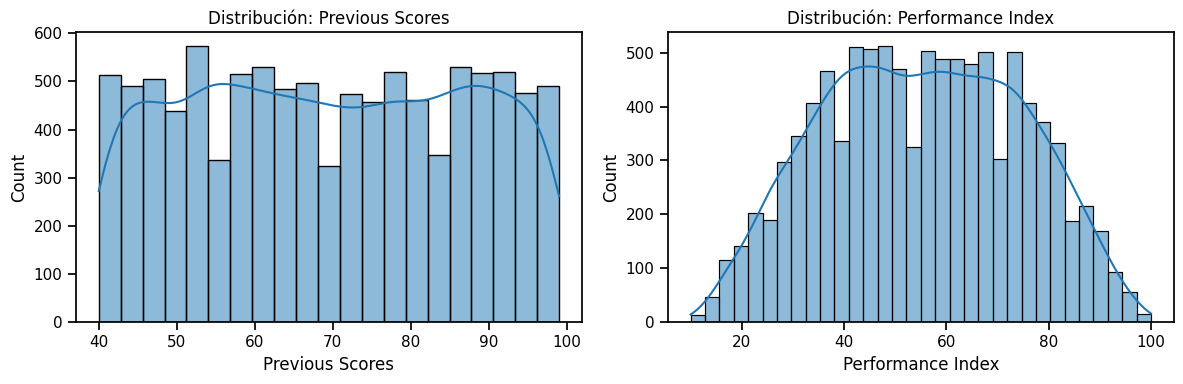

In [ ]:
# Quitamos esas columnas discretas del grid de histogramas
no_kde_cols = ["Hours Studied", "Sleep Hours", "Sample Question Papers Practiced"]
cols_to_plot = [c for c in num_cols if c not in no_kde_cols]

# Solo 2 gráficos -> 1 fila x 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes = axes.flatten()

for ax, c in zip(axes, cols_to_plot):
    if sns:
        sns.histplot(df[c], kde=True, ax=ax)
    else:
        ax.hist(df[c].dropna(), bins=30)
    ax.set_title(f"Distribución: {c}")
    ax.set_xlabel(c)

plt.tight_layout()
plt.show()


### Distribuciones
Podemos ver que previous Scores está distribuido de una manera casi uniforme, mientras que el desempeño se distribuye en forma de una campana.

Variables numéricas discretas: ['Hours Studied', 'Sleep Hours', 'Sample Question Papers Practiced']


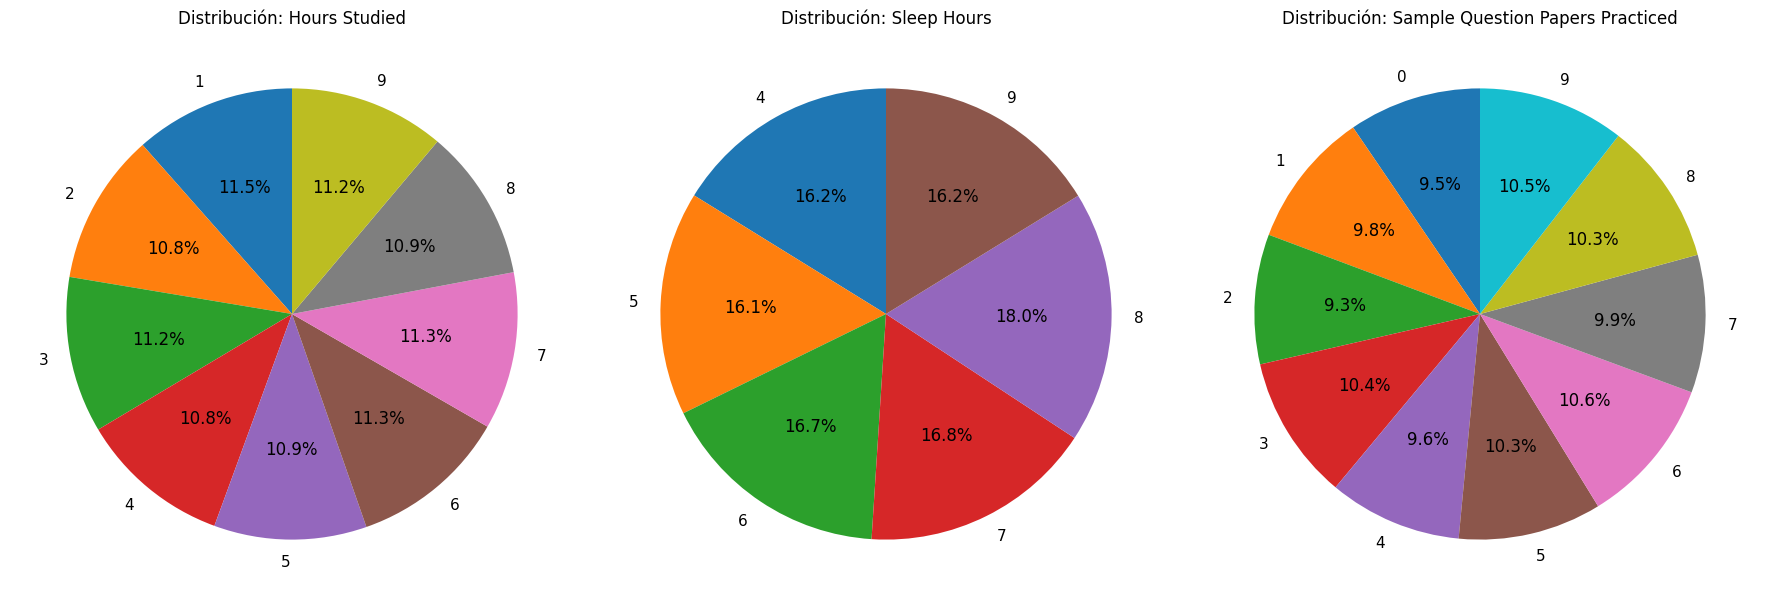

In [ ]:
discrete_num_cols = ['Hours Studied', 'Sleep Hours', 'Sample Question Papers Practiced']
print("Variables numéricas discretas:", discrete_num_cols)

# 1 figura con 3 pie plots (uno por variable)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, c in zip(axes, discrete_num_cols):
    vc = df[c].value_counts(dropna=False).sort_index()
    ax.pie(
        vc.values,
        labels=vc.index.astype(str),
        autopct="%1.1f%%",
        startangle=90
    )
    ax.set_title(f"Distribución: {c}")

plt.tight_layout()
plt.show()


### Pies
Todos los pies se distribuyen casi equitativamente entre los posibles valores.

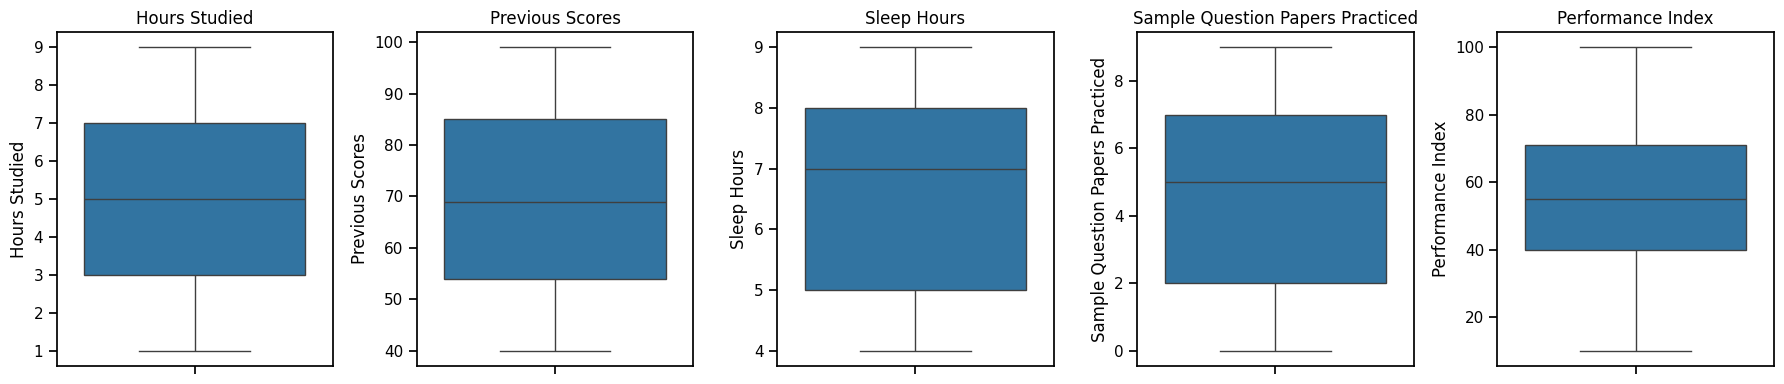

In [ ]:
# Boxplots para detectar outliers / rangos

fig, axes = plt.subplots(1, len(num_cols), figsize=(18, 4))

for ax, c in zip(axes, num_cols):
    if sns:
        sns.boxplot(y=df[c], ax=ax)
    else:
        ax.boxplot(df[c].dropna(), vert=True)
    ax.set_title(c)

plt.tight_layout()
plt.show()


### Cajas
No se ven outliers y las distribuciones de nuevo se confirman que son bastante uniformes excepto por performance que está más concentrado en el centro. Se puede observar que los estudiantes duermen las horas recomendadas y que llegan con niveles academicos muy variados.

,Performance Index
Performance Index,1.000000
Previous Scores,0.915189
Hours Studied,0.373730
Sleep Hours,0.048106
Sample Question Papers Practiced,0.043268


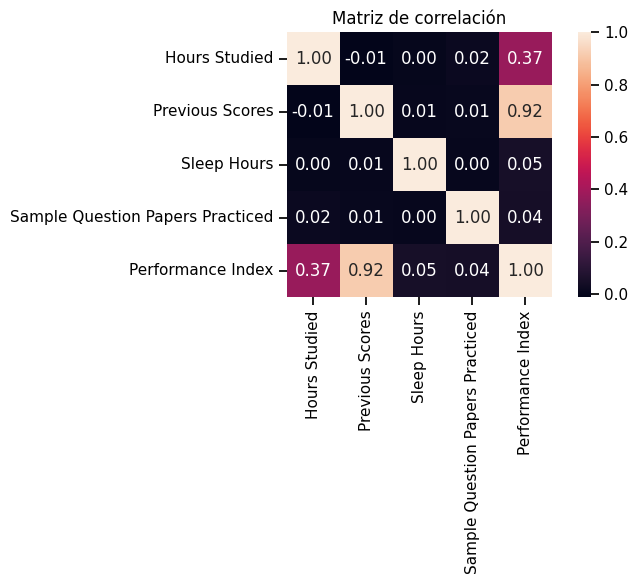

In [ ]:
# Correlaciones (numéricas)
COL_TARGET = "Performance Index"
corr = df[num_cols].corr(numeric_only=True)
display(corr.sort_values(COL_TARGET, ascending=False)[[COL_TARGET]])

plt.figure(figsize=(8,6))
if sns:
    sns.heatmap(corr, annot=True, fmt=".2f", square=True)
else:
    plt.imshow(corr, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()


### Correlación
Podemos ver correlaciones muy bajas en general excepto para el caso de 'Performance index' con 'Previous scores' y 'Hours studied'. A pesar de esta correlación, la variable Previous Scores no se elimina, ya que Performance Index se está utilizando como la variable dependiente en el análisis. Además con base en el nivel de los estudiantes, se puede analizar como influyen las horas de estudio, sueño y actividades externas en su aprendizaje, con el fin de predecir posibles tendencias en el transcurso del tiempo.

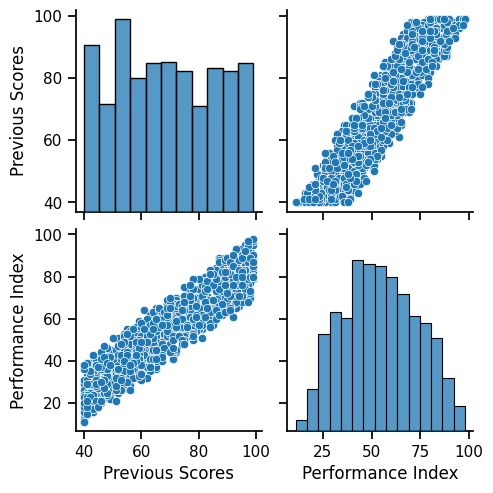

In [ ]:
# Pairplot para variabes continuas
cols_pairplot = ["Previous Scores", "Performance Index"]

sample_df = df[cols_pairplot].sample(1000, random_state=8756)

if sns:
    sns.pairplot(sample_df, diag_kind="hist")
    plt.show()
else:
    print("Seaborn no disponible; se omite pairplot.")


### Resultados
Los resultados previos y el desempeño se explican mutuamente de una manera notablemente lineal, esto nos indicaría que podemos usar una regresión lineal para la predicción del desempeño. Además de ello va acorde a lo esperado, para el aprendizaje se necesitan bases, por lo tanto el indice de desempeño tiene una alta correlacion con los puntajes previos, sin embargo, este tipo de datos es de cuidado debido a que podria generar metricas infladas y de esta manera haciendo que el modelo pierda validez.

## E — Explore (EDA Cualitativo + Gráficos)
Ahora analizamos variables categóricas (en este dataset principalmente **Extracurricular Activities**) y su relación con el desempeño.


In [ ]:
cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()
cat_cols


['Extracurricular Activities']


 Extracurricular Activities


,count,pct
Extracurricular Activities,,
No,5052,0.5052
Yes,4948,0.4948


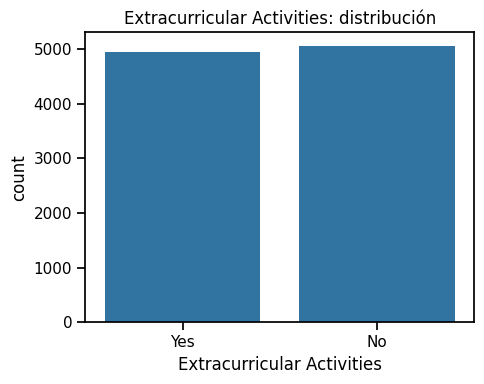

In [ ]:
# Distribución de categorías
for c in cat_cols:
    print("\n", c)
    display(df[c].value_counts(dropna=False).to_frame("count").assign(pct=lambda x: (x["count"]/len(df)).round(4)))
COL_EXTRA = "Extracurricular Activities"
plt.figure(figsize=(5,4))
if sns:
    sns.countplot(x=COL_EXTRA, data=df)
else:
    counts = df[COL_EXTRA].value_counts()
    plt.bar(counts.index.astype(str), counts.values)
plt.title(f"{COL_EXTRA}: distribución")
plt.tight_layout()
plt.show()


,count,mean,median,std
Extracurricular Activities,,,,
No,5052,54.758511,55.0,19.152068
Yes,4948,55.700889,55.0,19.264416


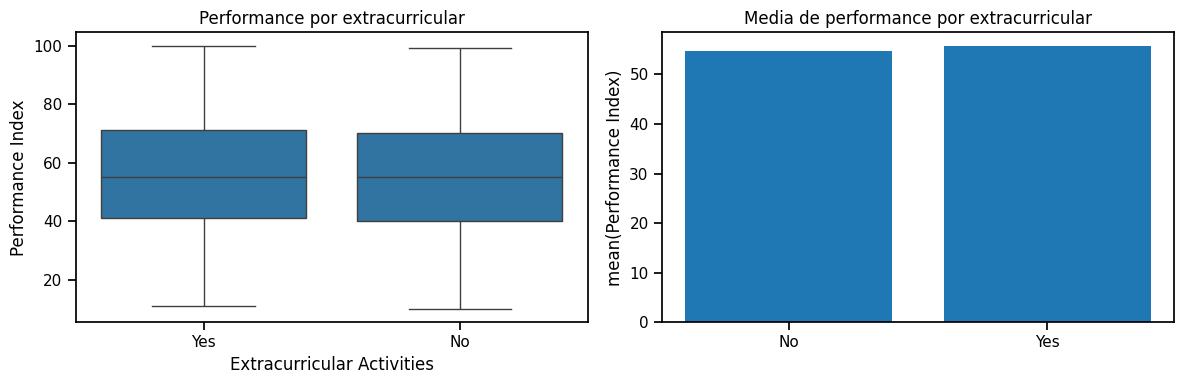

In [ ]:
# Comparación de desempeño según actividades extracurriculares
grp = df.groupby(COL_EXTRA)[COL_TARGET].agg(["count","mean","median","std"])
display(grp)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if sns:
    sns.boxplot(x=COL_EXTRA, y=COL_TARGET, data=df, ax=axes[0])
else:
    keys = df[COL_EXTRA].dropna().unique()
    data = [df.loc[df[COL_EXTRA]==k, COL_TARGET] for k in keys]
    axes[0].boxplot(data)
    axes[0].set_xticklabels(keys)
axes[0].set_title("Performance por extracurricular")

means = grp["mean"]
axes[1].bar(means.index.astype(str), means.values)
axes[1].set_title("Media de performance por extracurricular")
axes[1].set_ylabel(f"mean({COL_TARGET})")

plt.tight_layout()
plt.show()


performance_bucket,Alto,Perdido,Regular
Extracurricular Activities,,,
No,0.100,0.596,0.304
Yes,0.114,0.580,0.306


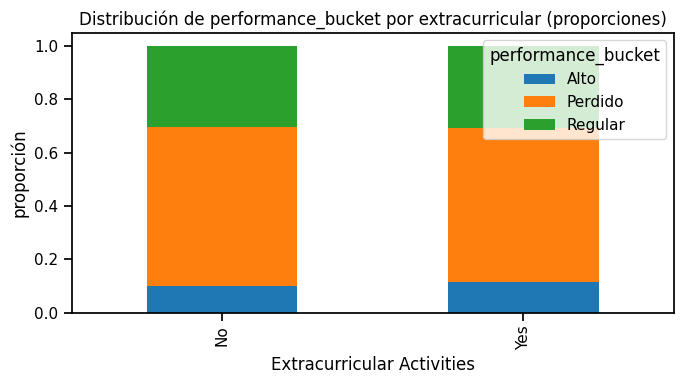

In [ ]:
# Segmentación: distribución de 'performance_bucket' por extracurricular
q1, q2 = df["Performance Index"].quantile([0.33, 0.66]).values
def perf_bucket(x):
    if x <= 60:
        return "Perdido"
    elif x <= 80:
        return "Regular"
    return "Alto"

df["performance_bucket"] = df["Performance Index"].apply(perf_bucket)
ct = pd.crosstab(df[COL_EXTRA], df["performance_bucket"], normalize="index").round(3)
display(ct)

ct.plot(kind="bar", stacked=True, figsize=(7,4))
plt.title("Distribución de performance_bucket por extracurricular (proporciones)")
plt.ylabel("proporción")
plt.tight_layout()
plt.show()


### Relación
Podemos ver que la distribución entre no tener actividades extracurriculares y tener, es bastante similar. No solo eso sino que se evidencia que no hay un gran impacto respecto al desempeño académico. Es decir, tener actividades academicas tiene poca influencia en el indice de desempeño de los estudiantes. Además el porcentaje de estudiantes que realizan actividades extracurriculares y los que no es muy similar, lo cual no genera sesgo en la extraccion de información y permite hablar con validez y fundamentos en cuanto al indice de desempeño y asumir que las actividades extracurriculares en la mayoria de los casos no influyen en el desempeño de los estudiantes.

## N — Interpret

Con base a los hallazgos presentados anteriormente, podemos observar una estrecha relación entre los hábitos académicos de los estudiantes y su indicador de desempeño, por lo que se tiene una base solida para la toma oportuna de decisiones institucionales que se orientan a la mejora del rendimiento académico. En particular, se observa que aquellos estudiantes que dedican más tiempo a estudiar y que practican con cuestionarios tipo examen obtienen mejores resultados, lo que sugiere una necesidad de fortalecer programas de acompañamiento académico y de incorporar estrategias de evaluación formativa que promuevan la preparación continua. Además, las evaluaciones previas nos ayudan a entender el rendimiento futuro de los estudiantes, por lo que pueden emplearse como una herramienta preventiva para identificar aquellos alumnos que se encuentren en situación de riesgo o presenten un bajo rendimiento,con el fin de implementar medidas correctivas y acciones tempranas en dichos individuos.

En los hallazgos también destacan la importancia de los factores de bienestar, como por ejemplo las horas de sueño, que impactan de manera positiva el rendimiento académico, por lo que la implementación de una política que promueva los hábitos saludables y una distribución equitativa de la carga académica ayudaría en gran medida a que los estudiantes cuyos exámenes fueron inferiores a la media, dándoles la oportunidad de mejorar. Finalmente, participar en actividades extracurriculares no afecta negativamente el rendimiento, lo que respalda la idea de promover una educación completa, siempre que se gestione bien el tiempo.

Finalmente, basar el modelo de indice de desempeño en los puntajes previos es sesgar un poco la información, ya que estamos partiendo de hechos del pasado que no consideran lo mencionado anteriormente, como son las horas de sueño, horas de estudio, actividades extracurriculares y variables que se desconocen y que generaron el desempeño de los estudiantes. Por tal motivo las metricas y la información presente se debe tomar en el estudio actual, haciendo uso de la información pero sin forzar al modelo con aspectos del pasado que se desconocen sus medidas y parametros. Esto con el fin de evitar un data leakage, es decir, un modelo que no aprenda patrones reales, sino que reconstruya la formula.





In [6]:
!git clone https://github.com/Momos20/fundamentos-ciencia-datos-2026-1.git





Cloning into 'fundamentos-ciencia-datos-2026-1'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 44 (delta 8), reused 7 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 991.23 KiB | 4.53 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [7]:
%cd fundamentos-ciencia-datos-2026-1
!ls -a


/content/fundamentos-ciencia-datos-2026-1
.  ..  EDA_OSEMN_StudentPerformance.ipynb  .git  README.md


In [9]:
!git checkout -b juan/rama



Switched to a new branch 'juan/rama'


In [10]:
!git branch


* juan/rama
  main


In [11]:
!git push -u origin juan/rama


fatal: could not read Username for 'https://github.com': No such device or address
